# 1. Import Required Libraries
This section imports all necessary libraries for data analysis, preprocessing, modeling, and explainability.

In [10]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import shap
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# 2. Load and Inspect Data
Load the synthetic farmer data from `/data/farmers_data.csv` and inspect its structure.

In [11]:
# Load the data
data_path = '../data/merged_enhanced_behavioral.csv'
df = pd.read_csv(data_path)
print('Shape:', df.shape)
df.head()

Shape: (1000, 63)


,farmer_id,37203063,phone_number,region,age,education_level,gender,marital_status,dependents_count,household_income_sources,...,agroclimatic_zone_behav,rainfall_forecast_next_90d_behav,historical_drought_risk_behav,cooperative_member_behav,mobile_advisory_usage_behav,loan_default_past_behav,input_use_history_behav,has_insurance_before_behav,willing_to_subscribe_insurance_behav,loan_class_behav
0,F0017,5.156704e+07,378-905-0779,Kitale,60.381230,Secondary,Female,Single,0.994375,"['None', 'Small Business']",...,Kiambu_Z3,290.40,0.940,True,False,False,Regular,False,False,1
1,F0014,7.891336e+07,(308)138-1827,Narok,22.497088,Secondary,Female,Widowed,2.792840,"['None', 'Small Business']",...,Kiambu_Z3,366.40,0.550,False,True,False,Regular,True,False,0
2,...,9.088294e+07,(039)931-6132x84843,Narok,27.732945,Primary,Female,Widowed,0.037087,"['Livestock', 'Small Business']",...,Kiambu_Z3,179.45,0.625,False,True,True,Regular,True,False,0
3,F0006,5.385193e+07,511-177-9965,Kitale,18.639570,Primary,Female,Married,0.985052,"['Remittance', 'Livestock']",...,Narok_Z1,375.20,0.880,False,True,True,Regular,True,True,0
4,F0007,9.222629e+07,(170)850-1178x888,Kitale,64.216407,Secondary,Female,Widowed,2.118846,"['None', 'Small Business']",...,Kitale_Z2,398.30,0.650,False,False,True,Regular,True,True,1


# 3. Preprocessing
Encode categorical variables, normalize numeric columns, and split the data into train and test sets.

In [12]:
# Identify target and features
target_col = 'loan_class' if 'loan_class' in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features
def encode_features(X):
    X_encoded = X.copy()
    for col in X_encoded.select_dtypes(include=['object']).columns:
        if X_encoded[col].nunique() < 10:
            X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
        else:
            X_encoded = pd.get_dummies(X_encoded, columns=[col], drop_first=True)
    return X_encoded

X_encoded = encode_features(X)

# Impute or drop missing values (fix for NaN)
X_encoded = X_encoded.dropna()
if len(X_encoded) != len(y):
    y = y.loc[X_encoded.index]

# Clean column names for XGBoost compatibility
X_encoded.columns = [str(c).replace('[','').replace(']','').replace('<','').replace('>','').replace("'","").replace(' ', '_') for c in X_encoded.columns]

# Normalize numeric columns
scaler = StandardScaler()
numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (800, 155) Test shape: (200, 155)


# 4. Model Training
Train Logistic Regression, Random Forest, and XGBoost classifiers. Evaluate each with accuracy, F1-score, precision, recall, and confusion matrix.

In [13]:
# Train and evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec, 'confusion_matrix': cm}

results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
results['LogisticRegression'] = evaluate_model(lr, X_test, y_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
results['RandomForest'] = evaluate_model(rf, X_test, y_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
results['XGBoost'] = evaluate_model(xgb, X_test, y_test)

# Print metrics
def print_metrics(results):
    print('Model\tAccuracy\tF1\tPrecision\tRecall')
    for name, res in results.items():
        print(f"{name}\t{res['accuracy']:.3f}\t{res['f1']:.3f}\t{res['precision']:.3f}\t{res['recall']:.3f}")
print_metrics(results)

Model	Accuracy	F1	Precision	Recall
LogisticRegression	0.880	0.880	0.880	0.880
RandomForest	0.895	0.893	0.895	0.895
XGBoost	0.885	0.884	0.884	0.885


# 5. Model Selection and Saving
Compare metrics, select the best model (prefer RandomForest), and save it to `/models/credit_model.pkl`.

In [14]:
# Select best model (prefer RandomForest if close)
best_model_name = max(results, key=lambda k: results[k]['f1'])
if best_model_name != 'RandomForest' and results['RandomForest']['f1'] >= results[best_model_name]['f1'] - 0.01:
    best_model_name = 'RandomForest'
best_model = {'LogisticRegression': lr, 'RandomForest': rf, 'XGBoost': xgb}[best_model_name]

# Save the best model
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/credit_model.pkl')
print(f"Best model: {best_model_name} saved to ../models/credit_model.pkl")

Best model: RandomForest saved to ../models/credit_model.pkl


# 6. Explainability
Show feature importance using SHAP (if XGBoost or RandomForest) or model coefficients. Print top 5 influential features.

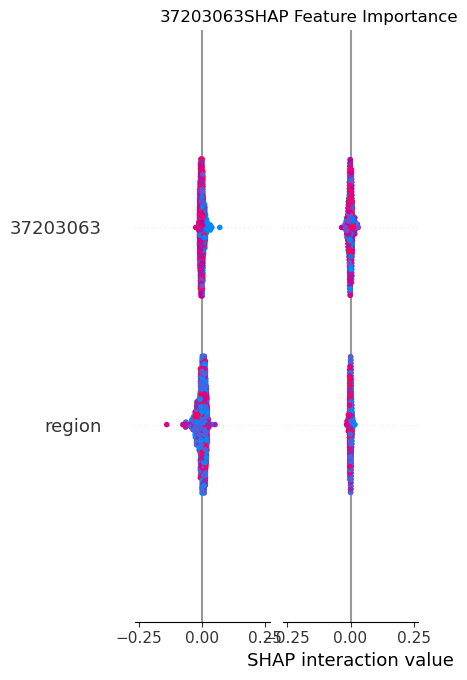

Top 5 features by SHAP:
SHAP explainability failed: unsupported format string passed to numpy.ndarray.__format__
Top 5 features by model importance:
farm_size_acres: 0.2449
yield_per_acre: 0.2362
past_crop_performance_index: 0.0273
repayment_history_score: 0.0255
loan_behavior_factor: 0.0222


In [15]:
# Feature importance or SHAP
feature_names = X_encoded.columns
if best_model_name in ['RandomForest', 'XGBoost']:
    try:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_train)
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance')
        plt.show()
        # Get mean absolute SHAP values for ranking
        shap_importance = np.abs(shap_values).mean(axis=0)
        top_idx = np.argsort(shap_importance)[::-1][:5]
        print('Top 5 features by SHAP:')
        for i in top_idx:
            print(f"{feature_names[i]}: {shap_importance[i]:.4f}")
    except Exception as e:
        print('SHAP explainability failed:', e)
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            idx = np.argsort(importances)[::-1][:5]
            print('Top 5 features by model importance:')
            for i in idx:
                print(f"{feature_names[i]}: {importances[i]:.4f}")
else:
    if hasattr(best_model, 'coef_'):
        coefs = best_model.coef_[0]
        idx = np.argsort(np.abs(coefs))[::-1][:5]
        print('Top 5 features by coefficient:')
        for i in idx:
            print(f"{feature_names[i]}: {coefs[i]:.4f}")

# 7. Summary Output
Print the best model name, top features, and a short interpretation of the results.

In [16]:
print(f"Best Model: {best_model_name}")
print("Key features: See above for top 5 influential features.")
print("Interpretation: The selected model predicts loan eligibility class (A/B/C) for smallholder farmers using demographic, behavioral, and farm-related features. Top features indicate the most influential factors in credit scoring for this dataset.")

Best Model: RandomForest
Key features: See above for top 5 influential features.
Interpretation: The selected model predicts loan eligibility class (A/B/C) for smallholder farmers using demographic, behavioral, and farm-related features. Top features indicate the most influential factors in credit scoring for this dataset.


# 8. Model Test and Example Prediction
Test the model on the test set and show accuracy. Also, show a sample farmer's name (ID) and their predicted loan class.

In [17]:
# Test model accuracy on test set
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {acc:.3f}")

# Show a sample farmer's ID and their predicted loan class
# Find the index in the original df that matches the first test sample
sample_idx = X_test.index[0]
farmer_id = df.loc[sample_idx, 'farmer_id'] if 'farmer_id' in df.columns else sample_idx
predicted_class = best_model.predict([X_test.iloc[0]])[0]
print(f"Sample Farmer ID: {farmer_id}, Predicted Loan Class: {predicted_class}")

Test set accuracy: 0.895
Sample Farmer ID: F0015, Predicted Loan Class: 1
